In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DTC dataset analysis 

Let's display the different columns

In [161]:
print(pd.read_csv(DTC_PATH, sep=",", header=0, nrows=0).columns.tolist())

['compound_id', 'standard_inchi_key', 'compound_name', 'synonym', 'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant', 'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation', 'standard_value', 'standard_units', 'activity_comment', 'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype', 'inhibitor_type', 'detection_tech', 'assay_cell_line', 'compound_concentration_value', 'compound_concentration_value_unit', 'substrate_type', 'substrate_relation', 'substrate_value', 'substrate_units', 'assay_description', 'title', 'journal', 'doc_type', 'annotation_comments']


In [162]:
DTC_PATH = "/home/olivier/data/idg_dream/DTC_data.csv"
# For now we will only look into this columns
COLUMNS_TO_LOAD = ['compound_id', 'standard_inchi_key', 'target_id', 'annotation_comments', 'standard_type', 
                   'standard_relation', 'standard_value', 'standard_units', 'mutation_info', 'assay_description']

In [163]:
dataset = pd.read_csv(DTC_PATH, sep=",", header=0, usecols=COLUMNS_TO_LOAD)
print(f"Size of the dwhole ataset : {len(dataset)}")

/home/olivier/miniconda3/envs/idg_dream/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,1,8,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Size of the dwhole ataset : 5980952


Let's remove lines that won't provide enough information for training

In [164]:
dataset.dropna(subset=['standard_type', 'standard_units', 'standard_inchi_key', 'target_id', 'standard_value', 
                       'standard_relation'], how='any', inplace=True)
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 3516514


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
126,CHEMBL492934,AAAAEENPAALFRN-UHFFFAOYSA-N,Q9UBL9,NaN,IC50,=,39.81,NM,Antagonist activity at human P2X2/3 receptor e...,NaN
127,CHEMBL492934,AAAAEENPAALFRN-UHFFFAOYSA-N,P49654,NaN,IC50,=,15.85,NM,Antagonist activity at rat P2X3 receptor expre...,NaN
128,CHEMBL246893,AAAAKTROWFNLEP-UHFFFAOYSA-N,P49137,NaN,IC50,>,20000.00,NM,Inhibition of MK2 after 30 mins by DELFIA,NaN
129,CHEMBL175513,AAAAZQPHATYWOK-JXMROGBWSA-N,P04626,NaN,IC50,=,64.00,NM,Inhibition of human epidermal growth factor re...,NaN
130,CHEMBL175513,AAAAZQPHATYWOK-JXMROGBWSA-N,P00533,NaN,IC50,=,188.00,NM,Inhibition of human epidermal growth factor re...,NaN


# Which lines correspond to KD endpoints?

First let's work on the standard_type columns which will help us filter the appropriate rows

In [165]:
dataset[dataset.standard_type.str.contains('kd', case=False)].standard_type.unique()

array(['KD', 'Kd', 'KDAPP', 'PKD', 'KD HYDRO', 'KD APP', "KD'", 'KD1',
       'KD2', 'KDISS', 'KDSPA', 'KD/KI', 'KDS', 'KDSPR'], dtype=object)

We will consider appropriate only the rows with the following standard_type values

In [166]:
kd_types = ['-LOG KD', 'KD', 'Kd', 'LOG 1/KD', 'LOG KD', 'LOGKD', 'PKD']

In [167]:
dataset = dataset[dataset.standard_type.isin(kd_types)]
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 75409


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
216,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,0.5,NM,Tested for the apparent dissociation constant ...,NaN
217,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,0.6,NM,Tested for the apparent dissociation constant ...,NaN
218,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,450.0,NM,Tested for the apparent dissociation constant ...,NaN
219,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1000.0,NM,Tested for the apparent dissociation constant ...,NaN
220,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1200.0,NM,Tested for the apparent dissociation constant ...,NaN


# What kind of units are used?

In [168]:
dataset.groupby('standard_units').size()

standard_units
-LOG(10) M       674
/S                 7
/UM                8
10'-1/S           30
10'-10L/MOL        1
10'-2/S           22
10'-3/S            8
10'-9L/MOL         1
KCAL/MOL           2
L M-1             18
MIN-1             30
MM                 9
NM             74556
NMOL/L            19
NO_UNIT            2
S-1               13
UG ML-1            6
UL/OD/MIN          3
dtype: int64

Considering the counts on units we will only use the following units for now

In [169]:
kd_units = ["NM", "-LOG(10) M"]

In [170]:
dataset = dataset[dataset.standard_units.isin(kd_units)]
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 75230


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
216,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,0.5,NM,Tested for the apparent dissociation constant ...,NaN
217,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,0.6,NM,Tested for the apparent dissociation constant ...,NaN
218,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,450.0,NM,Tested for the apparent dissociation constant ...,NaN
219,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1000.0,NM,Tested for the apparent dissociation constant ...,NaN
220,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1200.0,NM,Tested for the apparent dissociation constant ...,NaN


# Let's convert all units to M units as it is the contest used unit

In [171]:
def convert(x):
    unit = x['standard_units']
    value = x['standard_value']
    if unit == "NM":
        return [value * 1e-9, 'M']
    elif unit == "-LOG(10) M":
        return [10**(-value), 'M']
    else:
        print(x)
        raise

dataset[['standard_value', 'standard_units']] = dataset.apply(lambda row: pd.Series(convert(row)), axis=1)

In [172]:
dataset.head()

,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
216,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,5.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
217,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,6.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
218,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,4.500000e-07,M,Tested for the apparent dissociation constant ...,NaN
219,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.000000e-06,M,Tested for the apparent dissociation constant ...,NaN
220,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.200000e-06,M,Tested for the apparent dissociation constant ...,NaN


# What about the standard relation?

In [173]:
dataset.groupby('standard_relation').size()

standard_relation
<       201
<=       13
=     38823
>     36142
>=       14
~        37
dtype: int64

In [174]:
sup_standard_values = dataset[dataset.standard_relation == '>'].groupby('standard_value').size()

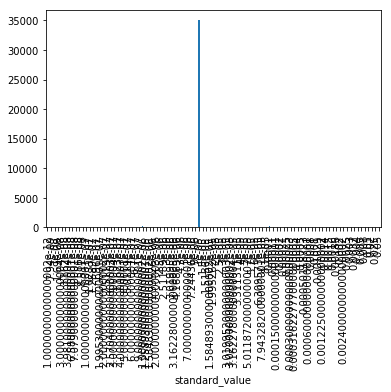

In [175]:
sup_standard_values.plot.bar()

In [176]:
(100*sup_standard_values/sup_standard_values.sum()).sort_values(ascending=False).head()

standard_value
0.000010    96.881744
0.000001     0.796857
0.000100     0.481434
0.000020     0.132809
0.005000     0.127276
dtype: float64

This part of the dataset is extremly biased and cannot be used : 1e-5 represent 96% of this part of the dataset and roughly 50% of the whole remaining dataset. We will thus only use the standard relation '='

In [177]:
dataset = dataset[dataset.standard_relation == '=']
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 38823


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
216,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,5.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
217,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,6.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
218,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,4.500000e-07,M,Tested for the apparent dissociation constant ...,NaN
219,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.000000e-06,M,Tested for the apparent dissociation constant ...,NaN
220,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.200000e-06,M,Tested for the apparent dissociation constant ...,NaN


# Sometimes the target_id column seems to contain more than one target

Those target_ids are separated by ","

In [178]:
len(dataset[dataset.target_id.str.contains(',')])

2979

We are not interested in complexes but only in 1-1 relationship between a drug and a target

In [179]:
dataset = dataset[~dataset.target_id.str.contains(',')]
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 35844


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
216,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,5.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
217,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,6.000000e-10,M,Tested for the apparent dissociation constant ...,NaN
218,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,4.500000e-07,M,Tested for the apparent dissociation constant ...,NaN
219,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.000000e-06,M,Tested for the apparent dissociation constant ...,NaN
220,CHEMBL135581,AAAKPBKWFMPTSQ-UHFFFAOYSA-N,P00374,NaN,KD,=,1.200000e-06,M,Tested for the apparent dissociation constant ...,NaN


# Are there any duplicates?

In [180]:
dataset[(dataset.standard_inchi_key == 'AAAKPBKWFMPTSQ-UHFFFAOYSA-N') & (dataset.target_id == 'P00374')].assay_description.tolist()

['Tested for the apparent dissociation constant for binding of compound to binary NADPH complex with human dihydrofolate reductase using equation 4',
 'Tested for the apparent dissociation constant for binding of compound to ternary NADPH complex with human dihydrofolate reductase using equation 4',
 'Tested for the apparent dissociation constant for binding of compound to ternary NADPH complex with human dihydrofolate reductase using equation 11',
 'Tested for the apparent dissociation constant for binding of compound to ternary NADPH complex with human dihydrofolate reductase using equations 15 and 16',
 'Tested for the apparent dissociation constant for binding of compound to binary NADPH complex with human dihydrofolate reductase using equations 11 and 12',
 'Apparent dissociation constant at pH 6.6 for human dihydrofolate reductase in the presence of cofactor NADPH',
 'Tested for the apparent dissociation constant for binding of compound to binary NADPH complex with human dihydrof

It looks difficult to remove the ambiguity, and it looks like there is much variation between measurements, we should probably remove duplicates...

In [181]:
grouped = dataset.groupby(['standard_inchi_key', 'target_id']).aggregate({'standard_value': np.mean, 'standard_units': 'count'})
grouped.head()

standard_value  standard_units
standard_inchi_key          target_id                                
AAAKPBKWFMPTSQ-UHFFFAOYSA-N P00374       2.077373e-06              11
AAAQFGUYHFJNHI-SFHVURJKSA-N O60885       6.853333e-08               6
                            P25440       1.161167e-07               6
                            Q15059       6.022500e-08               4
AADCDMQTJNYOSS-LBPRGKRZSA-N P61169       1.700000e-10               2

Let's see how many (target,compound) pairs have only one measurement

In [182]:
len(grouped[grouped.standard_units == 1])

19694

In [183]:
join_df = grouped[grouped.standard_units==1].reset_index()[['standard_inchi_key', 'target_id']]

In [184]:
dataset = dataset.merge(join_df,
                        on=['standard_inchi_key', 'target_id'], 
                        how = 'inner')
print(f"Size of the dataset after this filter : {len(dataset)}")
dataset.head()

Size of the dataset after this filter : 19694


,compound_id,standard_inchi_key,target_id,mutation_info,standard_type,standard_relation,standard_value,standard_units,assay_description,annotation_comments
0,CHEMBL52036,AADRGVCQNSFPFW-UHFFFAOYSA-N,P34976,NaN,KD,=,7.760000e-09,M,pA2 value determined in vitro against angioten...,NaN
1,CHEMBL404104,AAGINKIHSIMCMJ-STXWUJDDSA-J,P02751,NaN,KD,=,5.500000e-09,M,Binding affinity to fibronectin using surface ...,NaN
2,CHEMBL1448105,AAHPIJMQJAZYTM-UHFFFAOYSA-N,P27694,NaN,KD,=,6.270000e-04,M,Binding affinity to human RPA70N assessed as i...,NaN
3,CHEMBL3236571,AAINEFSCHYZRDZ-LLVKDONJSA-N,Q9H3N8,NaN,KD,=,3.980000e-09,M,Antagonist activity at human histamine H4 rece...,NaN
4,CHEMBL553,AAKJLRGGTJKAMG-UHFFFAOYSA-N,Q9Y2U5,NaN,KD,=,2.500000e-06,M,Binding constant for MAP3K2 kinase domain,NaN


# What about the standard value?

In [185]:
dataset.standard_value.describe(percentiles=[0.01, 0.1,0.25,0.50,0.75,0.9, 0.99])

count    1.969400e+04
mean     1.212129e-03
std      7.414883e-02
min      0.000000e+00
1%       7.995800e-11
10%      2.000000e-09
25%      1.995000e-08
50%      3.100000e-07
75%      2.900000e-06
90%      1.530000e-05
99%      1.753500e-03
max      1.000000e+01
Name: standard_value, dtype: float64

Some outliers seem to be remaining

In [186]:
dataset = dataset[(dataset.standard_value <= 1.7e-3) & (dataset.standard_value >= 1.e-10)]

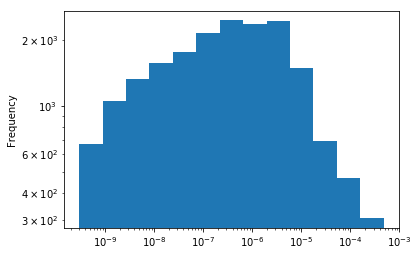

In [187]:
dataset.standard_value.plot.hist(bins=[1e-10*(3**x) for x in range(1,15)], logx=True, logy=True)

In [197]:
print(f"Final dataset length : {len(dataset)}")

Final dataset length : 19269
